# Wine Quality - Reducing Predictors

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, cross_validate
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import permutation_importance
import time
from sklearn.decomposition import PCA
from matplotlib.ticker import PercentFormatter
from sklearn.neighbors import KNeighborsClassifier

sns.set_style("whitegrid")

This code loads and displays the wine data and a trained 7-fold cross-validated quadratic DA model of redData. The table redData contains several features of red wine and the corresponding quality, which is saved in the QCLabel variable.

In [2]:
redData = pd.read_csv("./data/redWine.csv", dtype={'QCLabel': 'category'})
X, y = redData.iloc[:, :-1], redData.QCLabel
redData.head()

,FixedAcidity,VolatileAcidity,CitricAcid,ResidualSugar,Chlorides,FreeSulfurDioxide,TotalSulfurDioxide,Density,pH,Sulphates,Alcohol,QCLabel
0,0.2478,0.3973,0.00,0.0685,0.1068,0.1408,0.0989,0.5675,0.6063,0.1377,0.1538,D
1,0.2832,0.5205,0.00,0.1164,0.1436,0.3380,0.2155,0.4941,0.3622,0.2096,0.2154,D
2,0.2832,0.4384,0.04,0.0959,0.1336,0.1972,0.1696,0.5088,0.4094,0.1916,0.2154,D
3,0.5841,0.1096,0.56,0.0685,0.1052,0.2254,0.1908,0.5822,0.3307,0.1497,0.2154,C
4,0.2478,0.3973,0.00,0.0685,0.1068,0.1408,0.0989,0.5675,0.6063,0.1377,0.1538,D


In [3]:
classifier = LinearDiscriminantAnalysis()
kf = KFold(n_splits=7, shuffle=True)

start_time = time.time()
cv_results = cross_validate(classifier, X, y, cv=kf)
elapsed_time = time.time() - start_time

print("Accuracies:", cv_results['test_score'])
print("Mean accuracy:", cv_results['test_score'].mean())
print(f"Cross validation elapsed time: {elapsed_time:.4f} seconds")

Accuracies: [0.51315789 0.5877193  0.60087719 0.62719298 0.5814978  0.59911894
 0.59030837]
Mean accuracy: 0.5856960683647444
Cross validation elapsed time: 0.0745 seconds


## Reduce Predictors

Fit model with fewer predictors. Target accuracy value greater than 0.6.

### Method: Feature Selection (Tree)

In [4]:
classifier = DecisionTreeClassifier(random_state=0)
classifier.fit(X, y)

feature_importances = permutation_importance(classifier, X, y, n_repeats=10, random_state=0)
feature_importances = pd.DataFrame({'features': X.columns, 'importances_mean': feature_importances['importances_mean'], 
                                    'importances_std': feature_importances['importances_std']})
feature_importances.head()

,features,importances_mean,importances_std
0,FixedAcidity,0.074765,0.002869
1,VolatileAcidity,0.241933,0.006209
2,CitricAcid,0.093911,0.005546
3,ResidualSugar,0.153107,0.007639
4,Chlorides,0.104708,0.003549


<Figure size 640x480 with 0 Axes>

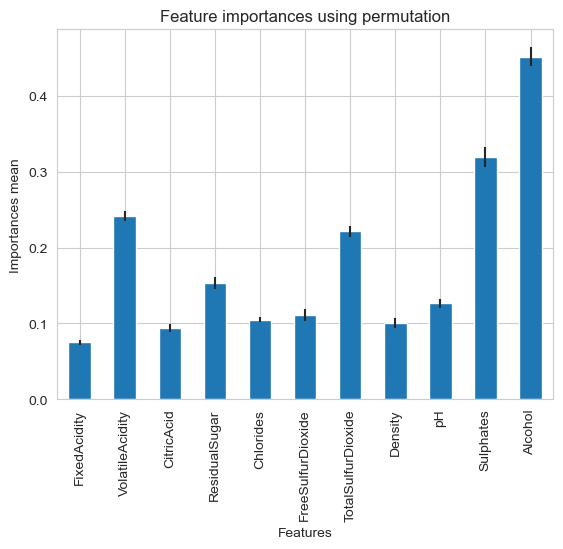

In [5]:
plt.figure()
feature_importances.plot.bar(x='features', y='importances_mean', yerr='importances_std', legend=None)
plt.title("Feature importances using permutation")
plt.xlabel("Features")
plt.ylabel("Importances mean")
plt.show()

In [6]:
fetures_keep = feature_importances['importances_mean'].sort_values(ascending=False)[:6].index
fetures_keep

X_selected = X[X.columns[fetures_keep]]
X_selected.head()

,Alcohol,Sulphates,VolatileAcidity,TotalSulfurDioxide,ResidualSugar,pH
0,0.1538,0.1377,0.3973,0.0989,0.0685,0.6063
1,0.2154,0.2096,0.5205,0.2155,0.1164,0.3622
2,0.2154,0.1916,0.4384,0.1696,0.0959,0.4094
3,0.2154,0.1497,0.1096,0.1908,0.0685,0.3307
4,0.1538,0.1377,0.3973,0.0989,0.0685,0.6063


In [7]:
classifier = DecisionTreeClassifier()
kf = KFold(n_splits=7, shuffle=True)

start_time = time.time()
cv_results = cross_validate(classifier, X_selected, y, cv=kf)
elapsed_time = time.time() - start_time

print("Accuracies:", cv_results['test_score'])
print("Mean accuracy:", cv_results['test_score'].mean())
print(f"Cross validation elapsed time: {elapsed_time:.4f} seconds")

Accuracies: [0.59210526 0.60964912 0.64035088 0.61403509 0.55506608 0.61674009
 0.5814978 ]
Mean accuracy: 0.6013491879478431
Cross validation elapsed time: 0.0685 seconds


### Method: Feature Transformation (PCA)

In [8]:
pca = PCA(n_components=X.shape[1])
X_pca = pca.fit_transform(X)
variance_ratio = pca.explained_variance_ratio_
pd.DataFrame(X_pca).head()

,0,1,2,3,4,5,6,7,8,9,10
0,-0.271835,-0.198480,-0.188124,0.026931,-0.064990,-0.045583,-0.050326,-0.053134,0.017260,0.024045,0.005965
1,-0.225726,-0.259009,0.019862,0.093234,0.112363,0.171550,-0.024661,0.039991,-0.009113,-0.036421,-0.021821
2,-0.187262,-0.181744,-0.090666,0.041260,0.057094,0.098733,-0.012322,0.032448,0.029553,-0.002964,-0.018298
3,0.422081,-0.031674,0.039251,-0.080673,0.094721,-0.119000,-0.032344,-0.043177,0.015405,0.028252,0.040900
4,-0.271835,-0.198480,-0.188124,0.026931,-0.064990,-0.045583,-0.050326,-0.053134,0.017260,0.024045,0.005965


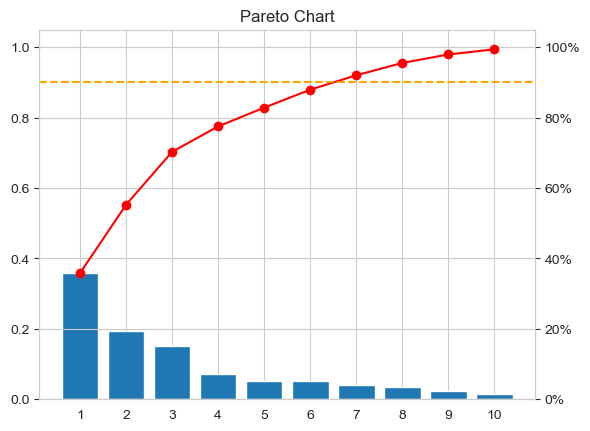

In [9]:
fig, ax = plt.subplots()

# Plot bars (i.e. frequencies)
ax.bar(np.arange(1, 11), variance_ratio[:10])
ax.set_ylim(0, variance_ratio.sum()*1.05)
ax.set_title("Pareto Chart")
ax.set_xticks(np.arange(1, 11))

# Second y axis (i.e. cumulative percentage)
ax2 = ax.twinx()
ax2.plot(np.arange(1, 11), (variance_ratio * 100).cumsum()[:10], color="red", marker="o")
ax2.axhline(90, color="orange", linestyle="dashed")
ax2.yaxis.set_major_formatter(PercentFormatter())
ax2.set_ylim(0, 100*1.05)

plt.show()

In [10]:
X_pca = X_pca[:, :3]
classifier = KNeighborsClassifier(n_neighbors=1)
kf = KFold(n_splits=7, shuffle=True)

start_time = time.time()
cv_results = cross_validate(classifier, X_pca, y, cv=kf)
elapsed_time = time.time() - start_time

print("Accuracies:", cv_results['test_score'])
print("Mean accuracy:", cv_results['test_score'].mean())
print(f"Cross validation elapsed time: {elapsed_time:.4f} seconds")

Accuracies: [0.5877193  0.6622807  0.55701754 0.60964912 0.63436123 0.67400881
 0.62114537]
Mean accuracy: 0.6208831550241242
Cross validation elapsed time: 0.0635 seconds
